# Overview: 

This notebook is created to do tasks given in issue no #9: [Comparing test sample classifications between models](https://github.com/mozilla/PRESC/issues/8)


## Task

- compare the classification results
    * Develop a visualization
    * Split out Misclassifications under either model




In [42]:
# Import basic libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# import visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
from ggplot import *
%matplotlib inline

#importing libraries for Decision tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold 

from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

In [25]:
df = pd.read_csv("../../datasets/defaults.csv")

In [30]:
df = df.rename(columns={'defaulted': 'def_pay','pay_0': 'pay_1'})
df.head()

,id,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,def_pay
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


# Machine Learning Model


**How do model performance be measured**

- During training we want the model to learn just the right level of rules for classification
- If model learns more detailed rules than necessary, it will make correct predictions on existing data but incorrect predictions on new data
- If model learns less detailed rules than necessary, it will make incorrect predicitons on existing data as well as new data


**Held Out Data Sample Setup**

- To evaluate if the model has learnt the right level of rules: 
 - we hide part of labeled data, called test data, from training process
 - train the model on remaining available data called training data
 - evaluate model performance on training data
 - evaluate model performance on test data
 - ensure that performance is as high as possible on test data while being similar to performance on training data


This is a classification problem and this means that we can use the following algorithms:

- Logistic regression
- Decision tree
- Random forest
- Support Vector Classifications
- Stocastic Gradient Descend
- Nearest Neighbours Classifiers
- Gaussian Process Classification
- Other ensemble
- Neural Network Models
- XGBoost

First I will work with decision tree. 


## Decision tree

Decision Trees are a class of very powerful Machine Learning model cable of achieving high accuracy in many tasks while being highly interpretable. What makes decision trees special in the realm of ML models is really their clarity of information representation. The *knowledge* learned by a decision tree through training is directly formulated into a hierarchical structure. This structure holds and displays the knowledge in such a way that it can easily be understood, even by non-experts.


The Tree is very easy to use and imagine, it can handle both numerical and categorical variables, but it is easy to fall into the trap of overfitting (i.e. creating a very complex model that perfectly describes training set but fails in predicting). It is also said to be senstive to small changes in the data, leading to different results. For this reason, it is common to use ensembles such as Random Forest to avoid this risk.

There are a few parameters to be settle for the classifier, such as the function to determine the quality of a split, or how deep the tree has to be. We will first test it with a random choice of those parameters and then see a better process.

Decison trees create a rules in form of a tree like flowchart. Decision trees are available in sklearn.tree library in form of class DecisionTreeClassifier.

In [31]:
# creating the target variable
y = df['def_pay'].copy()
y.sample(5)

3189     0
18761    0
25255    1
9781     1
23277    0
Name: def_pay, dtype: int64

In [8]:
# creating the features, which now will be everything in the original df
features = ['limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_1', 'pay_2',
       'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2',
       'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']
X = df[features].copy()
X.columns

Index(['limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_1', 'pay_2',
       'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2',
       'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6'],
      dtype='object')

Here I will train on 80% of the data and test on the remaining 20%. I chose the **80:20** ratio, training/validation split because this ratio gives the better result than other ratios, prevents overtraining of neural networks.

In [9]:
# split the df into train and test, it is important these two do not communicate during the training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [11]:
#createing the classifier
classifier = DecisionTreeClassifier(max_depth=10, random_state=14) 
# training the classifier
classifier.fit(X_train, y_train)
# doing predictions on the test
predictions = classifier.predict(X_test)


# see how good we did on the test
accuracy_score(y_true = y_test, y_pred = predictions)

0.812

**Accuracy: 81%**

Here I got the accuray 81% which is a result of a random choices on the parameters. 

Now trying overfitting by increasing the maximum depth of the tree.

In [12]:
classifier = DecisionTreeClassifier(max_depth=100, random_state=14) 
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)
accuracy_score(y_true = y_test, y_pred = predictions)

0.7231666666666666

So, we can see the accuracy has droped a lot.
To get the better parameters for this model, I am going to use GridSearchCV. 
GridSearchCV implements a “fit” and a “score” method. It also implements “predict”, “predict_proba”, “decision_function”, “transform” and “inverse_transform” if they are implemented in the estimator used.
Here, the more I complicate the grid, the longer it takes, because it is running it every time with a different combination of parameters.

Parameters I had used for DecisionTreeClassifier: 

- **criterion** can be gini (measures how often a randomly chosen element would be incorrectly identified) or entropy (measures the information contained by each attribute, thus we estimate the reduction in entropy due to sorting on the attribute)
- **max depth** is the maximum amount of steps the tree should do
- **max leaf** nodes maximum number of nodes
- **min_samples_split** a limit to stop further splitting, useful to avoid overfitting
- **random_state** is the seed used by the random number generator

In [18]:
# define the parameters grid
param_grid = {'max_depth': np.arange(3, 10),
             'criterion' : ['gini','entropy'],
             'max_leaf_nodes': [5,10,20,100],
             'min_samples_split': [2, 5, 10, 20]}

# create the grid
grid_tree = GridSearchCV(DecisionTreeClassifier(), param_grid, cv = 5, scoring= 'accuracy')
# the cv option will be clear in a few cells

#training
grid_tree.fit(X_train, y_train)
#let's see the best estimator
print(grid_tree.best_estimator_)
#with its score
print(np.abs(grid_tree.best_score_))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=20,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
0.8212916666666666


In [19]:
classifier = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=20,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)
accuracy_score(y_true = y_test, y_pred = predictions)

0.821

The accuracy got increased **0.07%** just by choosing the right parameters..

To cross validate, I will do another thing. I will use **Kfold**. 

K-fold cross-validation is a systematic process for repeating the train/test split procedure multiple times, in order to reduce the variance associated with a single trial of train/test split.

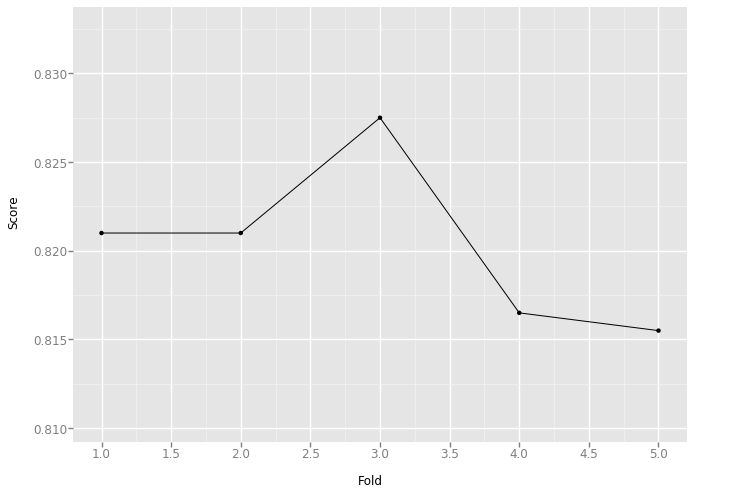

<ggplot: (-9223371921807010700)>


In [20]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)

fold = []
scr = []

for i,(train_index, test_index) in enumerate(kf.split(df)):
    training = df.iloc[train_index,:]
    valid = df.iloc[test_index,:]
    feats = training[features] #defined above
    label = training['def_pay']
    valid_feats = valid[features]
    valid_label = valid['def_pay']
    classifier.fit(feats,label) #it is the last one we run, the best one
    pred = classifier.predict(valid_feats)
    score = accuracy_score(y_true = valid_label, y_pred = pred)
    fold.append(i+1)
    scr.append(score)
    
#create a small df with the scores
performance = pd.DataFrame({'Score':scr,'Fold':fold})
# let's see what we have with ggplot
g = ggplot(performance,aes(x='Fold',y='Score')) + geom_point() + geom_line()
print(g)

Now, this does not mean much now, since it is only one model and, depending on how we split the df into train and test, we get a precision between 0.816 and 0.8275, which may or may not be relevant depending on the purpose of the model. 


Now I will work on other models.

In [33]:
# create the training df by remerging X_train and y_train
df_train = X_train.join(y_train)
df_train.sample(10)

,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,def_pay
4780,290000,1,2,1,30,0,0,0,0,0,0,351890,254163,250180,236027,221443,198031,11000,8607,8000,8525,8476,10000,0
28548,210000,2,2,2,33,0,0,0,-2,-2,-2,43047,9378,0,0,0,0,1000,0,0,0,0,0,0
1454,30000,1,2,2,26,0,0,0,0,0,0,33195,32705,32406,32167,31728,31061,1600,1500,1500,1300,1261,1003,0
3863,30000,1,2,2,39,1,2,2,0,0,0,1623,2441,3244,4034,4812,6210,1000,1000,1000,1000,1500,0,1
21983,200000,2,1,2,28,0,0,0,0,2,2,58833,61991,7357,9471,8538,7685,4100,3000,3000,0,1000,0,0
25720,280000,2,2,1,44,0,0,-1,-1,-2,-2,390,0,780,0,0,0,0,780,0,0,0,0,1
9369,360000,2,2,2,25,0,0,0,0,0,0,336179,173781,161223,145172,131346,134135,6781,7226,5032,5346,15003,15011,0
25736,30000,2,2,2,35,2,2,0,0,0,0,25368,24662,26001,27012,27241,27812,0,1739,1750,975,1010,3226,1
9780,210000,1,1,1,42,-1,-1,-1,-1,-1,-1,1729,1262,6867,2271,1054,1197,1315,6867,2271,1054,1197,701,0
4278,140000,2,2,2,27,0,0,0,0,0,0,111820,104189,100638,93092,94663,96257,3817,4500,3500,3600,3700,3500,0


In [35]:
# Separating majority and minority classes
df_majority = df_train[df_train.def_pay==0]
df_minority = df_train[df_train.def_pay==1]

print(df_majority.def_pay.count())
print("-----------")
print(df_minority.def_pay.count())
print("-----------")
print(df_train.def_pay.value_counts())

18677
-----------
5323
-----------
0    18677
1     5323
Name: def_pay, dtype: int64


In [36]:
# Upsampling minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=18677,    # to match majority class
                                 random_state=587) # reproducible results
# Combining majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
# Displaying new class counts
df_upsampled.def_pay.value_counts()

1    18677
0    18677
Name: def_pay, dtype: int64

In [37]:
# Downsampling majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=5323,     # to match minority class
                                 random_state=587) # reproducible results
# Combining minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
# Displaying new class counts
df_downsampled.def_pay.value_counts()

1    5323
0    5323
Name: def_pay, dtype: int64

The upsample has the disadvantage of increasing the likelihood of overfitting because it replicates the minority class event. It usually outperform the downsampling. The downsample can discard potentially useful information and the sample can be biased, but it helps improving the run time.

To create a syntetic sample I will use the **SMOTE algorithm**, which is an oversampling method which creates syntetic samples from the minority class instead of creating copies. It selects 2 or more similar instances and perturb them one at a time by random amount. This techniques should avoid overfitting problems but it risks adding noise to the model

In [41]:
sm = SMOTE(random_state=589, ratio = 1.0)
X_SMOTE, y_SMOTE = sm.fit_sample(X_train, y_train)
print(len(y_SMOTE))
print(y_SMOTE.sum())

37354
18677


So now I have 4 training sets:

- X_train, y_train, with their unbalance and their authenticity.
- df_upsample, which is balanced but at overfitting risk
- df_downsample, which will be fast but also potentially useless in terms of predictability (the test set is even bigger than it)
- X_SMOTE, y_SMOTE, which is syntetic and I don't really know it but should avoid overfitting

I will do everything 4 times for all models so that I can see the results and compare them following these steps.

- K-fold evaluation, run on different models should give us an idea on which one is more stable towards splitting of train and test
- Hyperparameter selection, so that we can have the best version of every algorithm
- Training
- Testing



# Algorithm Selection

the most commonly used technique is to use ensambles: combinations of different classifiers that create a more robust model. 

The main "classes" are:

- baggin ensambles: which reduce the chances of overfitting by running a series of uncostrained learners in parallel and combine them
- boosting ensambles: which improve the the flexibility of simple models by running a series of constrained learners in sequence. Each one of them will learn from the mistakes of the previous one. At the end it combines them in one unconstrained learner. 

For **Random Forest**, It trains on a large number of trees and combine them. The randomness comes from the fact that each tree is allowed to choose from a random subset of features to split on and each tree is trained on a random subset of observations.

For the **Gradient Tree Boosting**, it tries to minimize a loss function (difference between the real value and output of the learner) using the gradient descent method. Then there is **Ada-Boost** that trains the learners to make strong prediction by focusing on examples harder and harder to classify. This is done by assigning weights to the instances and increasing the one of missclassified one.

In [43]:
# classifier list for the normal training set
clf_list = [DecisionTreeClassifier(max_depth = 3, class_weight = "balanced"), 
            RandomForestClassifier(n_estimators = 100, class_weight = "balanced"), 
            AdaBoostClassifier(DecisionTreeClassifier(max_depth = 3, class_weight = "balanced"),
                               n_estimators = 100), 
            GradientBoostingClassifier(), 
            XGBClassifier()
           ]
# the parameters are set in order to have the same kind of tree every time

0
DecisionTreeClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier
XGBClassifier
1
DecisionTreeClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier
XGBClassifier
2
DecisionTreeClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier
XGBClassifier
3
DecisionTreeClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier
XGBClassifier
4
DecisionTreeClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier
XGBClassifier


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

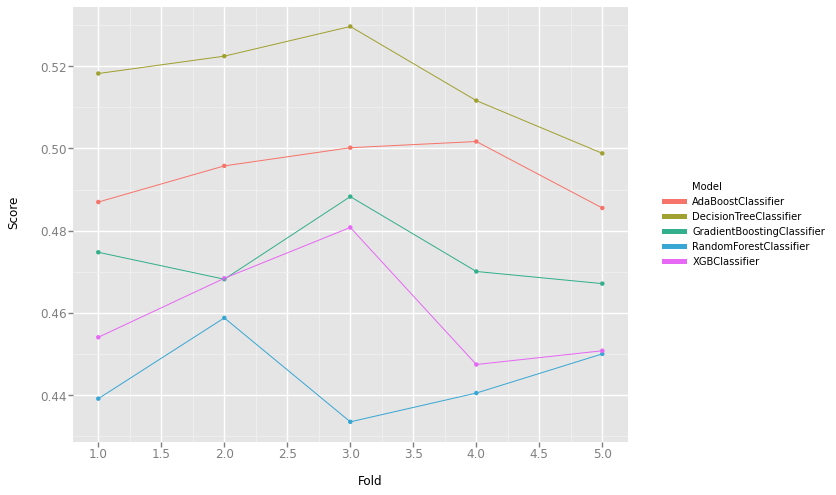

<ggplot: (-9223371944473494987)>


In [44]:
# using Kfold to evaluate the normal training set
kf = KFold(n_splits=5,random_state=42,shuffle=True)

mdl = []
fold = []
scr = []

for i,(train_index, test_index) in enumerate(kf.split(df_train)):
    training = df.iloc[train_index,:]
    valid = df.iloc[test_index,:]
    print(i)
    for clf in clf_list:
        model = clf.__class__.__name__
        feats = training[features] #defined above
        label = training['def_pay']
        valid_feats = valid[features]
        valid_label = valid['def_pay']
        clf.fit(feats,label) 
        pred = clf.predict(valid_feats)
        score = f1_score(y_true = valid_label, y_pred = pred)
        fold.append(i+1)
        scr.append(score)
        mdl.append(model)
        print(model)
    
#create a small df with the scores
performance = pd.DataFrame({'Model': mdl, 'Score':scr,'Fold':fold})
g_normal = ggplot(performance,aes(x='Fold',y='Score',group = 'Model',color = 'Model')) + geom_point() + geom_line()
print(g_normal)

In [45]:
# classifier list for the downsampled training set
clf_list = [DecisionTreeClassifier(max_depth = 3), 
            RandomForestClassifier(n_estimators = 100), 
            AdaBoostClassifier(DecisionTreeClassifier(max_depth = 3), n_estimators = 100), 
            GradientBoostingClassifier(), 
            XGBClassifier()
           ]
# the parameters are set in order to have the same kind of tree every time

0
DecisionTreeClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier
XGBClassifier
1
DecisionTreeClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier
XGBClassifier
2
DecisionTreeClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier
XGBClassifier
3
DecisionTreeClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier
XGBClassifier
4
DecisionTreeClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

XGBClassifier


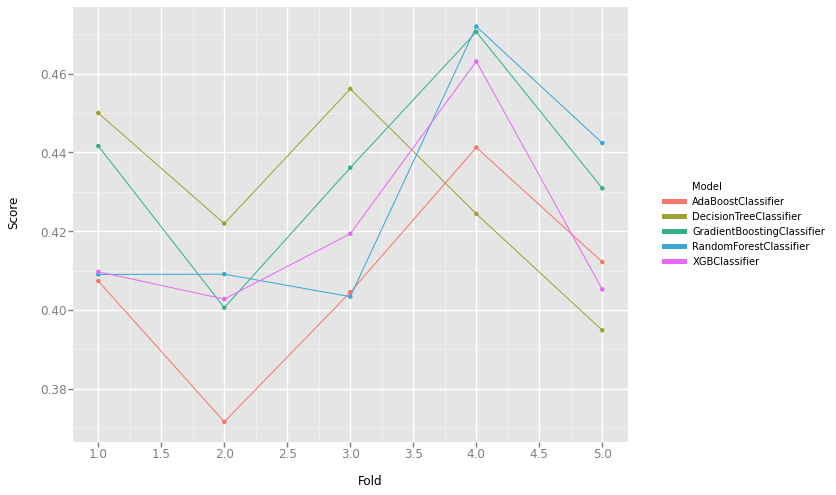

<ggplot: (-9223371944473504540)>


In [46]:
# use Kfold to evaluate the upsampled training set
kf = KFold(n_splits=5,random_state=42,shuffle=True)

mdl = []
fold = []
scr = []

for i,(train_index, test_index) in enumerate(kf.split(df_downsampled)):
    training = df.iloc[train_index,:]
    valid = df.iloc[test_index,:]
    print(i)
    for clf in clf_list:
        model = clf.__class__.__name__
        feats = training[features] #defined above
        label = training['def_pay']
        valid_feats = valid[features]
        valid_label = valid['def_pay']
        clf.fit(feats,label) 
        pred = clf.predict(valid_feats)
        score = f1_score(y_true = valid_label, y_pred = pred)
        fold.append(i+1)
        scr.append(score)
        mdl.append(model)
        print(model)
    
#create a small df with the scores
performance = pd.DataFrame({'Model': mdl, 'Score':scr,'Fold':fold})
g_downsampled = ggplot(performance,aes(x='Fold',y='Score',group = 'Model',color = 'Model')) + geom_point() + geom_line()
print(g_downsampled)

## Random Forest 

In [47]:
# normal training set
param_grid = {'n_estimators': [200, 400, 600, 1000], # It is going to be a long search
              'criterion': ['entropy', 'gini'],
              'class_weight' : ['balanced'], 'n_jobs' : [-1]} #use all the computational power you have
acc_scorer = make_scorer(f1_score)
grid_forest = GridSearchCV(RandomForestClassifier(), param_grid, scoring = acc_scorer, cv=5)
%time grid_forest = grid_forest.fit(X_train, y_train)
print(grid_forest.best_estimator_)
print(grid_forest.best_score_)
forest_normal = grid_forest.best_estimator_

Wall time: 16min 51s
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=400, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
0.46630328509534713


In [49]:
#cell added because on Kaggle it takes too much time to run
forest_normal = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=400, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
print(0.449643478486)

0.449643478486


In [50]:
y_upsampled = df_upsampled.def_pay
X_upsampled = df_upsampled.drop(['def_pay'], axis= 1)

In [51]:
# upsampled training set
param_grid = {'n_estimators': [200, 400, 600, 1000],
              'criterion': ['entropy', 'gini'], 'n_jobs' : [-1]}
acc_scorer = make_scorer(f1_score)
grid_forest = GridSearchCV(RandomForestClassifier(), param_grid, scoring = acc_scorer, cv=5)
%time grid_forest = grid_forest.fit(X_upsampled, y_upsampled)
print(grid_forest.best_estimator_)
print(grid_forest.best_score_)
forest_upsampled = grid_forest.best_estimator_

Wall time: 21min 55s
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.9387242775359916


In [52]:
#cell added because on Kaggle it takes too much time to run
forest_upsampled = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
print(0.93295704261)

0.93295704261


In [53]:
y_downsampled = df_downsampled.def_pay
X_downsampled = df_downsampled.drop(['def_pay'], axis = 1)

In [54]:
# downsampled training set
param_grid = {'n_estimators': [200, 400, 600, 1000],
              'criterion': ['entropy', 'gini'], 'n_jobs' : [-1]}
acc_scorer = make_scorer(f1_score)
grid_forest = GridSearchCV(RandomForestClassifier(), param_grid, scoring = acc_scorer, cv=5)
%time grid_forest = grid_forest.fit(X_downsampled, y_downsampled)
print(grid_forest.best_estimator_)
print(grid_forest.best_score_)
forest_downsampled = grid_forest.best_estimator_

Wall time: 6min 14s
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.6886778708385062


In [55]:
forest_downsampled = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
print(0.686692645307)

0.686692645307


In [ ]:
# SMOTE training set
param_grid = {'n_estimators': [200, 400, 600, 1000],
              'criterion': ['entropy', 'gini'], 'n_jobs' : [-1]}
acc_scorer = make_scorer(f1_score)
grid_forest = GridSearchCV(RandomForestClassifier(), param_grid, scoring = acc_scorer, cv=5)
%time grid_forest = grid_forest.fit(X_SMOTE, y_SMOTE)
print(grid_forest.best_estimator_)
print(grid_forest.best_score_)
forest_SMOTE = grid_forest.best_estimator_

In [ ]:
forest_SMOTE = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
print(0.831423121548)

# Ada Boost Classifier 


In [ ]:
# normal training set
param_grid = {'n_estimators': [200,300],
              'algorithm': ['SAMME', 'SAMME.R'],
              'learning_rate' : [0.5, 0.75, 1.0]}
acc_scorer = make_scorer(f1_score)
grid_ada = GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier(class_weight = "balanced")), 
                        param_grid, scoring = acc_scorer, cv=5)
%time grid_ada = grid_ada.fit(X_train, y_train)
print(grid_ada.best_estimator_)
print(grid_ada.best_score_)
ada_normal = grid_ada.best_estimator_


In [ ]:
ada_normal = AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.75, n_estimators=300, random_state=None)
print(0.408435692436)

In [ ]:
# upsampled training set

param_grid = {'n_estimators': [200,300],
              'algorithm': ['SAMME', 'SAMME.R'],
              'learning_rate' : [0.5, 0.75, 1.0]}
acc_scorer = make_scorer(f1_score)
grid_ada = GridSearchCV(AdaBoostClassifier(), param_grid, scoring = acc_scorer, cv=5)
%time grid_ada = grid_ada.fit(X_upsampled, y_upsampled)
print(grid_ada.best_estimator_)
print(grid_ada.best_score_)
ada_upsampled = grid_ada.best_estimator_

In [ ]:
ada_upsampled = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=300, random_state=None)
print(0.689430792925)

In [ ]:
# downsampled training set
param_grid = {'n_estimators': [200,300],
              'algorithm': ['SAMME', 'SAMME.R'],
              'learning_rate' : [0.5, 0.75, 1.0]}
acc_scorer = make_scorer(f1_score)
grid_ada = GridSearchCV(AdaBoostClassifier(), param_grid, scoring = acc_scorer, cv=5)
%time grid_ada = grid_ada.fit(X_downsampled, y_downsampled)
print(grid_ada.best_estimator_)
print(grid_ada.best_score_)
ada_downsampled = grid_ada.best_estimator_

In [ ]:
ada_downsampled = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=200, random_state=None)
print(0.673783146613)

In [ ]:
# SMOTE training set
param_grid = {'n_estimators': [200,300],
              'algorithm': ['SAMME', 'SAMME.R'],
              'learning_rate' : [0.5, 0.75, 1.0]}
acc_scorer = make_scorer(f1_score)
grid_ada = GridSearchCV(AdaBoostClassifier(), param_grid, scoring = acc_scorer, cv=5)
%time grid_ada = grid_ada.fit(X_SMOTE, y_SMOTE)
print(grid_ada.best_estimator_)
print(grid_ada.best_score_)
ada_SMOTE = grid_ada.best_estimator_


In [ ]:
ada_SMOTE = AdaBoostClassifier(algorithm='SAMME', base_estimator=None, learning_rate=0.5,
          n_estimators=200, random_state=None)
print(0.797835003041)

# Gradient Boost


In [ ]:
# normal training set
param_grid = {'n_estimators': [200,300],
              'learning_rate' : [0.5, 0.75, 1.0]}
acc_scorer = make_scorer(f1_score)
grid_gbc = GridSearchCV(GradientBoostingClassifier(), param_grid, scoring = acc_scorer, cv=5)
%time grid_gbc = grid_gbc.fit(X_train, y_train)
print(grid_gbc.best_estimator_)
print(grid_gbc.best_score_)
gbc_normal = grid_gbc.best_estimator_

In [ ]:
gbc_normal = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.5, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
print(0.443888650557)

In [ ]:
#upsampled training set
param_grid = {'n_estimators': [200,300],
              'learning_rate' : [0.5, 0.75, 1.0]}
acc_scorer = make_scorer(f1_score)
grid_gbc = GridSearchCV(GradientBoostingClassifier(), param_grid, scoring = acc_scorer, cv=5)
%time grid_gbc = grid_gbc.fit(X_upsampled, y_upsampled)
print(grid_gbc.best_estimator_)
print(grid_gbc.best_score_)
gbc_upsampled = grid_gbc.best_estimator_

In [ ]:
gbc_upsampled = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=1.0, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
print(0.831025217754)

In [ ]:
#downsampled training set
param_grid = {'n_estimators': [200,300],
              'learning_rate' : [0.5, 0.75, 1.0]}
acc_scorer = make_scorer(f1_score)
grid_gbc = GridSearchCV(GradientBoostingClassifier(), param_grid, scoring = acc_scorer, cv=5)
%time grid_gbc = grid_gbc.fit(X_downsampled, y_downsampled)
print(grid_gbc.best_estimator_)
print(grid_gbc.best_score_)
gbc_downsampled = grid_gbc.best_estimator_

In [ ]:
gbc_downsampled = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.5, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
print(0.67183972731)

In [ ]:
param_grid = {'n_estimators': [200,300],
              'learning_rate' : [0.5, 0.75, 1.0]}
acc_scorer = make_scorer(f1_score)
grid_gbc = GridSearchCV(GradientBoostingClassifier(), param_grid, scoring = acc_scorer, cv=5)
%time grid_gbc = grid_gbc.fit(X_SMOTE, y_SMOTE)
print(grid_gbc.best_estimator_)
print(grid_gbc.best_score_)
gbc_SMOTE = grid_gbc.best_estimator_

In [ ]:
gbc_SMOTE = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.5, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
print(0.78976849349)

The common result is that the model trained on the normal dataset, which is unbalanced, gives a lower f1 score. 

This also shows that the one with balanced options do not perform as well as one that learned on a balanced sample. The upsampled learners seem to be more promising but, as mentioned, they fall into the overfitting trap more often.

# Training and testing
It is time to see how well our models perform for real. I will run them all and hopefully see significant differences in how they reach a result.

## Random Forests

In [ ]:
# Normal sample training
%time forest_normal.fit(X_train, y_train)
predictions = forest_normal.predict(X_test)
print("-------------")
print("f1 score: {}".format(round(f1_score(y_true = y_test, y_pred = predictions),3)))
print("Accuracy: {}".format(round(accuracy_score(y_true = y_test, y_pred = predictions),3)))
print("-------------")
print(get_feature_importance(forest_normal, features))
print("-------------")
TP = np.sum(np.logical_and(predictions == 1, y_test == 1))
TN = np.sum(np.logical_and(predictions == 0, y_test == 0))
FP = np.sum(np.logical_and(predictions == 1, y_test == 0))
FN = np.sum(np.logical_and(predictions == 0, y_test == 1))
pred = len(predictions)

print('True Positives: {}'.format(TP))
print('False Positive: {}'.format(FP))
print('True Negative: {}'.format(TN))
print('False Negative: {}'.format(FN))
print('Precision: {}'.format(round(TP/(TP+FP),2)))
print('Recall: {}'.format(round(TP/(TP+FN),2)))
print('Problematic ratio: {}'.format(round(FN/(FN+TP),2)))

In [ ]:
# Upsample training
%time forest_upsampled.fit(X_upsampled, y_upsampled)
predictions = forest_upsampled.predict(X_test)
print("-------------")
print("f1 score: {}".format(round(f1_score(y_true = y_test, y_pred = predictions),3)))
print("Accuracy: {}".format(round(accuracy_score(y_true = y_test, y_pred = predictions),3)))
print("-------------")
print(get_feature_importance(forest_upsampled, features))
print("-------------")
TP = np.sum(np.logical_and(predictions == 1, y_test == 1))
TN = np.sum(np.logical_and(predictions == 0, y_test == 0))
FP = np.sum(np.logical_and(predictions == 1, y_test == 0))
FN = np.sum(np.logical_and(predictions == 0, y_test == 1))
pred = len(predictions)

print('True Positives: {}'.format(TP))
print('False Positive: {}'.format(FP))
print('True Negative: {}'.format(TN))
print('False Negative: {}'.format(FN))
print('Precision: {}'.format(round(TP/(TP+FP),2)))
print('Recall: {}'.format(round(TP/(TP+FN),2)))
print('Problematic ratio: {}'.format(round(FN/(FN+TP),2)))

In [ ]:
# Downsample training
%time forest_downsampled.fit(X_downsampled, y_downsampled)
predictions = forest_downsampled.predict(X_test)
print("-------------")
print("f1 score: {}".format(round(f1_score(y_true = y_test, y_pred = predictions),3)))
print("Accuracy: {}".format(round(accuracy_score(y_true = y_test, y_pred = predictions),3)))
print("-------------")
print(get_feature_importance(forest_downsampled, features))
print("-------------")
TP = np.sum(np.logical_and(predictions == 1, y_test == 1))
TN = np.sum(np.logical_and(predictions == 0, y_test == 0))
FP = np.sum(np.logical_and(predictions == 1, y_test == 0))
FN = np.sum(np.logical_and(predictions == 0, y_test == 1))
pred = len(predictions)

print('True Positives: {}'.format(TP))
print('False Positive: {}'.format(FP))
print('True Negative: {}'.format(TN))
print('False Negative: {}'.format(FN))
print('Precision: {}'.format(round(TP/(TP+FP),2)))
print('Recall: {}'.format(round(TP/(TP+FN),2)))
print('Problematic ratio: {}'.format(round(FN/(FN+TP),2)))

In [ ]:
# SMOTE training
%time forest_SMOTE.fit(X_SMOTE, y_SMOTE)
predictions = forest_SMOTE.predict(X_test)
print("-------------")
print("f1 score: {}".format(round(f1_score(y_true = y_test, y_pred = predictions),3)))
print("Accuracy: {}".format(round(accuracy_score(y_true = y_test, y_pred = predictions),3)))
print("-------------")
print(get_feature_importance(forest_SMOTE, features))
print("-------------")
TP = np.sum(np.logical_and(predictions == 1, y_test == 1))
TN = np.sum(np.logical_and(predictions == 0, y_test == 0))
FP = np.sum(np.logical_and(predictions == 1, y_test == 0))
FN = np.sum(np.logical_and(predictions == 0, y_test == 1))
pred = len(predictions)

print('True Positives: {}'.format(TP))
print('False Positive: {}'.format(FP))
print('True Negative: {}'.format(TN))
print('False Negative: {}'.format(FN))
print('Precision: {}'.format(round(TP/(TP+FP),2)))
print('Recall: {}'.format(round(TP/(TP+FN),2)))
print('Problematic ratio: {}'.format(round(FN/(FN+TP),2)))

## Ada Boost


In [ ]:
# Normal sample training
%time ada_normal.fit(X_train, y_train)
predictions = ada_normal.predict(X_test)
print("-------------")
print("f1 score: {}".format(round(f1_score(y_true = y_test, y_pred = predictions),3)))
print("Accuracy: {}".format(round(accuracy_score(y_true = y_test, y_pred = predictions),3)))
print("-------------")
print(get_feature_importance(ada_normal, features))
print("-------------")
TP = np.sum(np.logical_and(predictions == 1, y_test == 1))
TN = np.sum(np.logical_and(predictions == 0, y_test == 0))
FP = np.sum(np.logical_and(predictions == 1, y_test == 0))
FN = np.sum(np.logical_and(predictions == 0, y_test == 1))
pred = len(predictions)

print('True Positives: {}'.format(TP))
print('False Positive: {}'.format(FP))
print('True Negative: {}'.format(TN))
print('False Negative: {}'.format(FN))
print('Precision: {}'.format(round(TP/(TP+FP),2)))
print('Recall: {}'.format(round(TP/(TP+FN),2)))
print('Problematic ratio: {}'.format(round(FN/(FN+TP),2)))

In [ ]:
# Upsample training
%time ada_upsampled.fit(X_upsampled, y_upsampled)
predictions = ada_upsampled.predict(X_test)
print("-------------")
print("f1 score: {}".format(round(f1_score(y_true = y_test, y_pred = predictions),3)))
print("Accuracy: {}".format(round(accuracy_score(y_true = y_test, y_pred = predictions),3)))
print("-------------")
print(get_feature_importance(ada_upsampled, features))
print("-------------")
TP = np.sum(np.logical_and(predictions == 1, y_test == 1))
TN = np.sum(np.logical_and(predictions == 0, y_test == 0))
FP = np.sum(np.logical_and(predictions == 1, y_test == 0))
FN = np.sum(np.logical_and(predictions == 0, y_test == 1))
pred = len(predictions)

print('True Positives: {}'.format(TP))
print('False Positive: {}'.format(FP))
print('True Negative: {}'.format(TN))
print('False Negative: {}'.format(FN))
print('Precision: {}'.format(round(TP/(TP+FP),2)))
print('Recall: {}'.format(round(TP/(TP+FN),2)))
print('Problematic ratio: {}'.format(round(FN/(FN+TP),2)))

In [ ]:
# Downsample training
%time ada_downsampled.fit(X_downsampled, y_downsampled)
predictions = ada_downsampled.predict(X_test)
print("-------------")
print("f1 score: {}".format(round(f1_score(y_true = y_test, y_pred = predictions),3)))
print("Accuracy: {}".format(round(accuracy_score(y_true = y_test, y_pred = predictions),3)))
print("-------------")
print(get_feature_importance(ada_downsampled, features))
print("-------------")
TP = np.sum(np.logical_and(predictions == 1, y_test == 1))
TN = np.sum(np.logical_and(predictions == 0, y_test == 0))
FP = np.sum(np.logical_and(predictions == 1, y_test == 0))
FN = np.sum(np.logical_and(predictions == 0, y_test == 1))
pred = len(predictions)

print('True Positives: {}'.format(TP))
print('False Positive: {}'.format(FP))
print('True Negative: {}'.format(TN))
print('False Negative: {}'.format(FN))
print('Precision: {}'.format(round(TP/(TP+FP),2)))
print('Recall: {}'.format(round(TP/(TP+FN),2)))
print('Problematic ratio: {}'.format(round(FN/(FN+TP),2)))

In [ ]:
# SMOTE training
%time ada_SMOTE.fit(X_SMOTE, y_SMOTE)
predictions = ada_SMOTE.predict(X_test)
print("-------------")
print("f1 score: {}".format(round(f1_score(y_true = y_test, y_pred = predictions),3)))
print("Accuracy: {}".format(round(accuracy_score(y_true = y_test, y_pred = predictions),3)))
print("-------------")
print(get_feature_importance(ada_SMOTE, features))
print("-------------")
TP = np.sum(np.logical_and(predictions == 1, y_test == 1))
TN = np.sum(np.logical_and(predictions == 0, y_test == 0))
FP = np.sum(np.logical_and(predictions == 1, y_test == 0))
FN = np.sum(np.logical_and(predictions == 0, y_test == 1))
pred = len(predictions)

print('True Positives: {}'.format(TP))
print('False Positive: {}'.format(FP))
print('True Negative: {}'.format(TN))
print('False Negative: {}'.format(FN))
print('Precision: {}'.format(round(TP/(TP+FP),2)))
print('Recall: {}'.format(round(TP/(TP+FN),2)))
print('Problematic ratio: {}'.format(round(FN/(FN+TP),2)))

## Gradient Boosting


In [ ]:
# Normal sample training
%time gbc_normal.fit(X_train, y_train)
predictions = gbc_normal.predict(X_test)
print("-------------")
print("f1 score: {}".format(round(f1_score(y_true = y_test, y_pred = predictions),3)))
print("Accuracy: {}".format(round(accuracy_score(y_true = y_test, y_pred = predictions),3)))
print("-------------")
print(get_feature_importance(gbc_normal, features))
print("-------------")
TP = np.sum(np.logical_and(predictions == 1, y_test == 1))
TN = np.sum(np.logical_and(predictions == 0, y_test == 0))
FP = np.sum(np.logical_and(predictions == 1, y_test == 0))
FN = np.sum(np.logical_and(predictions == 0, y_test == 1))
pred = len(predictions)

print('True Positives: {}'.format(TP))
print('False Positive: {}'.format(FP))
print('True Negative: {}'.format(TN))
print('False Negative: {}'.format(FN))
print('Precision: {}'.format(round(TP/(TP+FP),2)))
print('Recall: {}'.format(round(TP/(TP+FN),2)))
print('Problematic ratio: {}'.format(round(FN/(FN+TP),2)))

In [ ]:
# Upsample training
%time gbc_upsampled.fit(X_upsampled, y_upsampled)
predictions = gbc_upsampled.predict(X_test)
print("-------------")
print("f1 score: {}".format(round(f1_score(y_true = y_test, y_pred = predictions),3)))
print("Accuracy: {}".format(round(accuracy_score(y_true = y_test, y_pred = predictions),3)))
print("-------------")
print(get_feature_importance(gbc_upsampled, features))
print("-------------")
TP = np.sum(np.logical_and(predictions == 1, y_test == 1))
TN = np.sum(np.logical_and(predictions == 0, y_test == 0))
FP = np.sum(np.logical_and(predictions == 1, y_test == 0))
FN = np.sum(np.logical_and(predictions == 0, y_test == 1))
pred = len(predictions)

print('True Positives: {}'.format(TP))
print('False Positive: {}'.format(FP))
print('True Negative: {}'.format(TN))
print('False Negative: {}'.format(FN))
print('Precision: {}'.format(round(TP/(TP+FP),2)))
print('Recall: {}'.format(round(TP/(TP+FN),2)))
print('Problematic ratio: {}'.format(round(FN/(FN+TP),2)))

In [ ]:
# Downsample training
%time gbc_downsampled.fit(X_downsampled, y_downsampled)
predictions = gbc_downsampled.predict(X_test)
print("-------------")
print("f1 score: {}".format(round(f1_score(y_true = y_test, y_pred = predictions),3)))
print("Accuracy: {}".format(round(accuracy_score(y_true = y_test, y_pred = predictions),3)))
print("-------------")
print(get_feature_importance(gbc_downsampled, features))
print("-------------")
TP = np.sum(np.logical_and(predictions == 1, y_test == 1))
TN = np.sum(np.logical_and(predictions == 0, y_test == 0))
FP = np.sum(np.logical_and(predictions == 1, y_test == 0))
FN = np.sum(np.logical_and(predictions == 0, y_test == 1))
pred = len(predictions)

print('True Positives: {}'.format(TP))
print('False Positive: {}'.format(FP))
print('True Negative: {}'.format(TN))
print('False Negative: {}'.format(FN))
print('Precision: {}'.format(round(TP/(TP+FP),2)))
print('Recall: {}'.format(round(TP/(TP+FN),2)))
print('Problematic ratio: {}'.format(round(FN/(FN+TP),2)))

In [ ]:
# SMOTE training
%time gbc_SMOTE.fit(X_SMOTE, y_SMOTE)
predictions = gbc_SMOTE.predict(X_test)
print("-------------")
print("f1 score: {}".format(round(f1_score(y_true = y_test, y_pred = predictions),3)))
print("Accuracy: {}".format(round(accuracy_score(y_true = y_test, y_pred = predictions),3)))
print("-------------")
print(get_feature_importance(gbc_SMOTE, features))
print("-------------")
TP = np.sum(np.logical_and(predictions == 1, y_test == 1))
TN = np.sum(np.logical_and(predictions == 0, y_test == 0))
FP = np.sum(np.logical_and(predictions == 1, y_test == 0))
FN = np.sum(np.logical_and(predictions == 0, y_test == 1))
pred = len(predictions)

print('True Positives: {}'.format(TP))
print('False Positive: {}'.format(FP))
print('True Negative: {}'.format(TN))
print('False Negative: {}'.format(FN))
print('Precision: {}'.format(round(TP/(TP+FP),2)))
print('Recall: {}'.format(round(TP/(TP+FN),2)))
print('Problematic ratio: {}'.format(round(FN/(FN+TP),2)))